In [1]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
from sklearn.decomposition import PCA

In [2]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 0

print(mat_files[idx])

FileNotFoundError: [Errno 2] No such file or directory: 'data_np/'

In [ ]:
image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

20s_long_heating_refl_50Hz_2.5J_-70°C_2_PA.npy


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


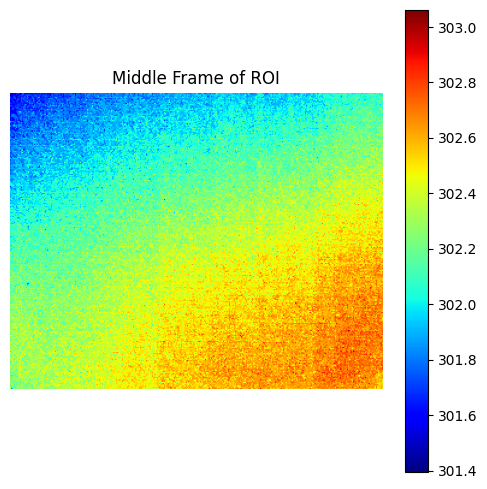

In [ ]:
# y1, y2, x1, x2 = 72, 316, 159, 410
# image_sequence = image_sequence[y1:y2, x1:x2, :]

image_sequence = image_sequence[:, 120:470, :]

h, w, t = image_sequence.shape
middle_frame = image_sequence[:, :, t // 2]
plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

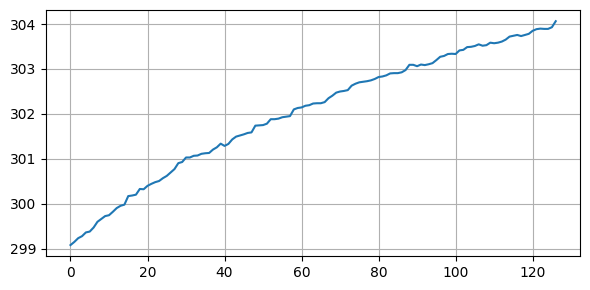

165


In [ ]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 139

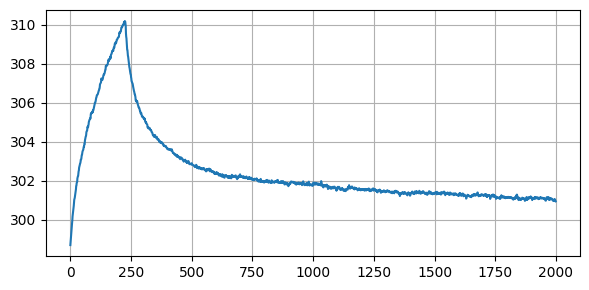

In [ ]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True))

latent_dim = n_components

In [ ]:
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x
    
class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()
        
        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')        
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=4
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')
        
        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)
        
        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)
        
        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )
        

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)
        
        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:2500]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")
 
print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 5.3075 | Recon = 5.2114 | Z = 0.0961
Epoch 10: Total Loss = 0.0377 | Recon = 0.0115 | Z = 0.0261
Epoch 20: Total Loss = 0.0164 | Recon = 0.0053 | Z = 0.0110
Epoch 30: Total Loss = 0.0130 | Recon = 0.0049 | Z = 0.0081
Epoch 40: Total Loss = 0.0101 | Recon = 0.0045 | Z = 0.0057
Epoch 50: Total Loss = 0.0078 | Recon = 0.0039 | Z = 0.0039
Epoch 60: Total Loss = 0.0062 | Recon = 0.0034 | Z = 0.0027
Epoch 70: Total Loss = 0.0056 | Recon = 0.0037 | Z = 0.0019
Epoch 80: Total Loss = 0.0047 | Recon = 0.0034 | Z = 0.0014
Epoch 90: Total Loss = 0.0049 | Recon = 0.0036 | Z = 0.0012
Epoch 100: Total Loss = 0.0043 | Recon = 0.0033 | Z = 0.0010


In [ ]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())
        
principal_comp = torch.cat(all_latents, dim=0).numpy()

In [ ]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

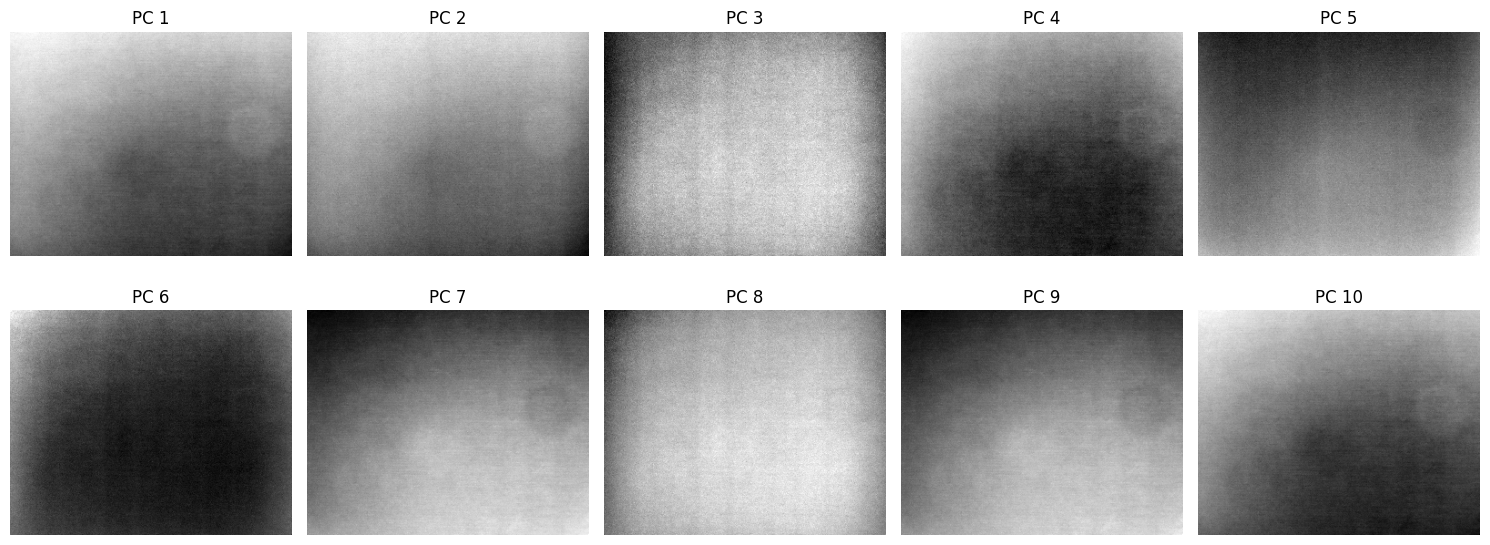

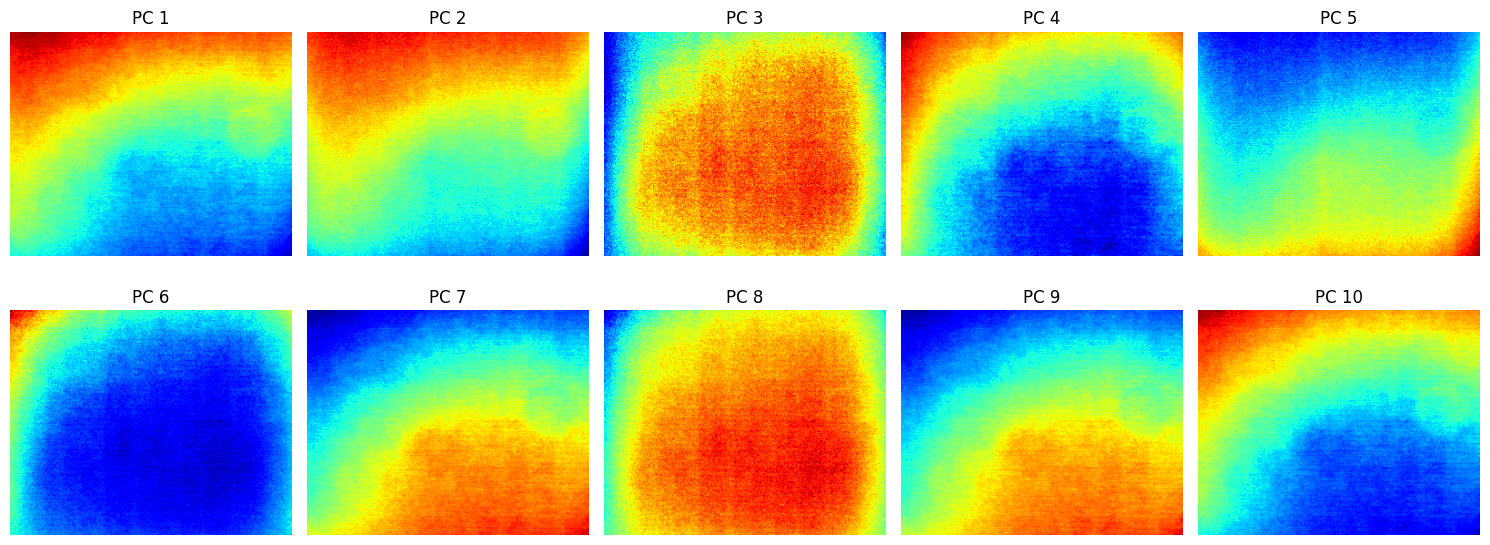

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

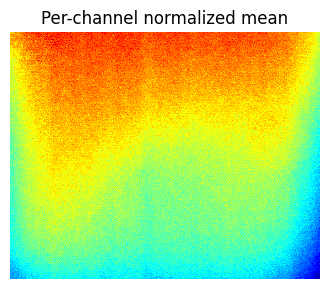

In [ ]:
import torch
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

C, H, W = pca_array.shape
flat = pca_array.reshape(C, -1).T

pca = PCA(n_components=1)
pca_result = pca.fit_transform(flat)
comp = pca_result.reshape(H, W)

p1 = np.percentile(comp, 1)
p99 = np.percentile(comp, 99)
comp = np.clip(comp, p1, p99)
comp = (comp - p1) / (p99 - p1 + 1e-8)
comp = (comp * 255).astype(np.uint8)

bgr = cv2.applyColorMap(comp, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(comp, cv2.COLOR_GRAY2RGB)

plt.figure(figsize=(3, 3))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# import torch
# import cv2
# import numpy as np
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# C, H, W = pca_array.shape
# flat = pca_array.reshape(C, -1).T

# pca = PCA(n_components=1)
# pca_result = pca.fit_transform(flat)
# comp = pca_result.reshape(H, W)

# comp -= comp.min()
# comp /= comp.max()
# comp = (comp * 255).astype(np.uint8)

# gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
# img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

# plt.figure(figsize=(3, 3))
# plt.imshow(img_rgb, cmap='gray')
# plt.axis('off')
# plt.show()

In [ ]:
import re, json, torch, numpy as np, cv2, matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from transformers import AutoModelForCausalLM, LlamaTokenizer

tokenizer = LlamaTokenizer.from_pretrained("lmsys/vicuna-7b-v1.5", use_fast=False)
model = AutoModelForCausalLM.from_pretrained(
    "THUDM/cogvlm-grounding-generalist-hf",
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
).eval()

/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 8/8 [00:14<00:00,  1.80s/it]
/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/m123/anaconda3/envs/cogvlm/lib/python3.10/site-packages/transformers/generation/utils.py:1460: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


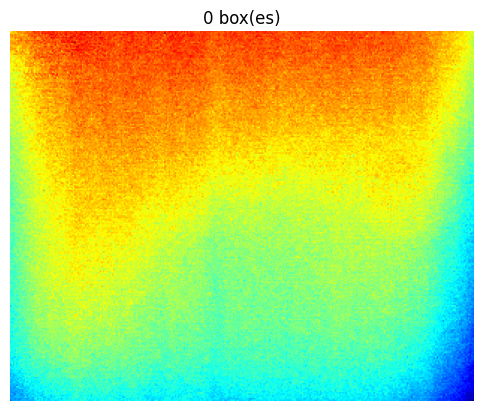

Find the defect [[000,000,997,996]]. The defect [[000,000,997,996]] is a stain. [[000,000,997,996]] So the answer is stain.
boxes (0–1000): []
boxes (pixels): []


In [ ]:
query = 'Detect the defects. Detect each defect and describe its type, size, and location.'
image = Image.fromarray(img_rgb).convert("RGB")
W, H = image.size

conv = model.build_conversation_input_ids(tokenizer, query=query, images=[image])
 
inputs = {"input_ids": conv["input_ids"].unsqueeze(0),
          "attention_mask": conv["attention_mask"].unsqueeze(0)}
if conv.get("token_type_ids") is not None:
    inputs["token_type_ids"] = conv["token_type_ids"].unsqueeze(0)
imgs = conv.get("images", None)
if imgs is not None and len(imgs) > 0 and imgs[0] is not None:
    t = imgs[0][0] if isinstance(imgs[0], list) and len(imgs[0]) > 0 else imgs[0]
    inputs["images"] = [[t.to(dtype=torch.float16)]]

with torch.inference_mode():
    out = model.generate(**inputs, max_length=2048, do_sample=False)
    out = out[:, inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(out[0], skip_special_tokens=True)

m = re.search(r"\{.*\}", text, flags=re.S)
boxes_rel = []
if m:
    try:
        boxes_rel = json.loads(m.group(0)).get("boxes", [])
    except:
        boxes_rel = []
if not boxes_rel:
    arr = re.findall(r"\[\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\](?:\s*,\s*\[\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\]\s*)*\s*\]", text)
    if arr:
        try:
            boxes_rel = json.loads(arr[0])
        except:
            boxes_rel = []

boxes_px = []
for b in boxes_rel:
    if isinstance(b, (list, tuple)) and len(b) == 4:
        x1 = int(round(b[0] / 1000.0 * W)); y1 = int(round(b[1] / 1000.0 * H))
        x2 = int(round(b[2] / 1000.0 * W)); y2 = int(round(b[3] / 1000.0 * H))
        if x2 > x1 and y2 > y1:
            boxes_px.append((x1, y1, x2, y2))

img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
for (x1, y1, x2, y2) in boxes_px:
    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"{len(boxes_px)} box(es)")
plt.show()

print(text)
print("boxes (0–1000):", boxes_rel)
print("boxes (pixels):", boxes_px)